In [3]:
import os
from obspy import read

# since 'data' is in the same folder as your notebook, just say:
data_folder = "data"

all_traces = []

for file_name in os.listdir(data_folder):
    if file_name.endswith(".seg2"):
        file_path = os.path.join(data_folder, file_name)
        st = read(file_path)
        all_traces.extend(st)

print(f"Loaded {len(all_traces)} traces from {len(os.listdir(data_folder))} files.")


Loaded 360 traces from 15 files.


... | 2022-06-13T22:05:59.000000Z - 2022-06-13T22:06:00.999500Z | 2000.0 Hz, 4000 samples


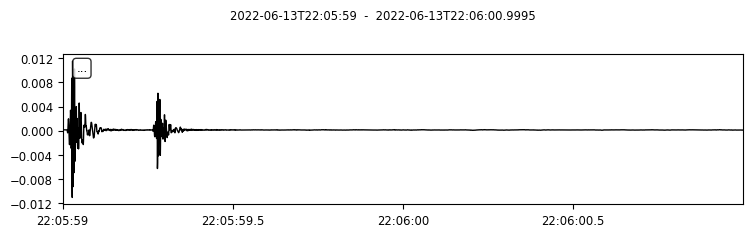

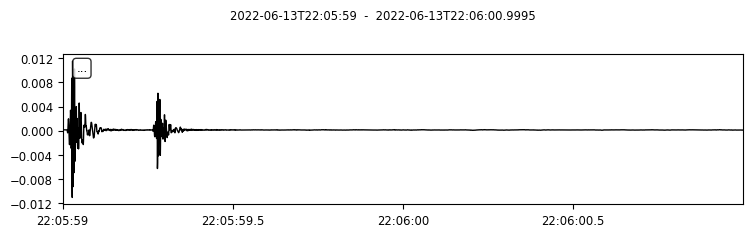

In [4]:
# Look at one example trace
trace = all_traces[0]
print(trace)

# Plot it
trace.plot()


In [6]:
import numpy as np
import pandas as pd
from obspy import read
from obspy.signal.trigger import classic_sta_lta
import glob
from tqdm.notebook import tqdm # Optional: for a nice progress bar
from sklearn.utils import shuffle

# ==============================================================================
# 1. Configuration Parameters (ADJUSTED FOR IMBALANCE)
# ==============================================================================

# File location
file_pattern = 'data/*.seg2' 

# Time parameters (scientifically chosen based on your 2s trace and 2000 Hz)
segment_duration_s = 0.2  # Length of each final data sample (400 samples)
STA_LEN = 0.05            # Short-Term Average Window (100 samples)
LTA_LEN = 0.8             # Long-Term Average Window (1600 samples) 

# --- IMBALANCE FIXES BELOW ---
TRIGGER_ON = 1.5          # DECREASED: Lower threshold makes the detector more sensitive to weaker events.
EVENT_DURATION_S = 1.0    # INCREASED: Take a longer window (1.0s) after the onset to generate more Class 1 samples.
# --- IMBALANCE FIXES ABOVE ---

# Storage for all final data
final_segments = []
final_labels = []

# ==============================================================================
# 2. Main Processing Loop
# ==============================================================================

print("Starting automated data extraction with adjusted parameters...")

# Use glob to find all files matching the pattern
all_files = glob.glob(file_pattern)

if not all_files:
    print(f"Error: No files found matching '{file_pattern}'. Check your directory structure and file names.")

for filename in tqdm(all_files, desc="Processing Files"):
    try:
        # Load the SEG2 file (ObsPy reads most formats, including SEG2)
        st = read(filename)
    except Exception as e:
        print(f"Skipping file {filename} due to error: {e}")
        continue

    # Process all traces (your 24 channels) in the file
    for trace in st:
        
        # --- Crucial Check: Ensure correct sample rate is being used ---
        if trace.stats.sampling_rate != 2000.0:
             # Use the rate from the trace if it differs, but warn the user
             print(f"Warning: Trace from {filename} has sample rate {trace.stats.sampling_rate} Hz, not 2000 Hz. Using trace rate.")
        
        trace.detrend("linear")
        sampling_rate = trace.stats.sampling_rate
        npts = trace.stats.npts
        
        # Calculate window sizes in number of samples based on the actual sampling_rate
        npts_segment = int(segment_duration_s * sampling_rate)
        npts_sta = int(STA_LEN * sampling_rate)
        npts_lta = int(LTA_LEN * sampling_rate)
        npts_event_duration = int(EVENT_DURATION_S * sampling_rate)
        
        # Safety Check
        if npts_lta >= npts:
            print(f"Skipping trace: LTA window ({LTA_LEN}s) is too long for the trace ({npts/sampling_rate}s).")
            continue


        # ----------------------------------------------------
        # 2A. Find Event Onset using STA/LTA
        # ----------------------------------------------------
        
        # Calculate the STA/LTA characteristic function (cft)
        cft = classic_sta_lta(trace.data, npts_sta, npts_lta)
        
        # Find the first point where the ratio crosses the trigger threshold
        trigger_indices = np.where(cft > TRIGGER_ON)[0]

        if len(trigger_indices) == 0:
            # If no clear trigger, the whole trace is considered quiet
            onset_sample = npts 
        else:
            # The onset is the first trigger index, plus the LTA length (to account for time shift)
            onset_sample = trigger_indices[0] + npts_lta

        # ----------------------------------------------------
        # 2B. Extract and Segment QUIET Data (Class 0)
        # ----------------------------------------------------
        
        # The quiet data is from the start up to the event onset
        quiet_data = trace.data[:onset_sample]
        
        # Iterate and slice the quiet data into fixed-size segments
        current_start = 0
        while (current_start + npts_segment) <= len(quiet_data):
            segment = quiet_data[current_start : current_start + npts_segment]
            final_segments.append(segment)
            final_labels.append(0) # Label as 'Non-Mining'
            current_start += npts_segment # Move to the next segment
            
        # ----------------------------------------------------
        # 2C. Extract and Segment EVENT Data (Class 1)
        # ----------------------------------------------------
        
        # The event data starts at the onset, and lasts for the defined duration (now 1.0s)
        event_end_sample = min(onset_sample + npts_event_duration, npts)

        # We take multiple, highly overlapping segments (75% overlap) to augment the event data
        if (event_end_sample - onset_sample) >= npts_segment:
            # Step size for 75% overlap (0.25 * npts_segment)
            step_size = npts_segment // 4 
            # Ensure step size is at least 1 sample
            if step_size < 1: step_size = 1 
            
            for shift in range(0, npts_event_duration - npts_segment + 1, step_size): 
                segment = trace.data[onset_sample + shift : onset_sample + shift + npts_segment]
                if len(segment) == npts_segment:
                    final_segments.append(segment)
                    final_labels.append(1) # Label as 'Mining Proxy'

# ==============================================================================
# 3. Create Final Data Structure for ML
# ==============================================================================

# Convert the list of arrays (segments) into a single 2D NumPy array
X_data = np.vstack(final_segments)
y_labels = np.array(final_labels)

# Put into a DataFrame for easy inspection and use with ML models
df = pd.DataFrame(X_data)
df['label'] = y_labels

print("\n--- Summary --- (ADJUSTED PARAMETERS)")
print(f"Total Segments Extracted: {len(df)}")
print(f"Class 0 (Quiet) Samples: {len(df[df['label'] == 0])}")
print(f"Class 1 (Event) Samples: {len(df[df['label'] == 1])}")

# Final step: Shuffle the data before training the model
df_shuffled = shuffle(df).reset_index(drop=True)

print("\nData is ready for training (df_shuffled)! Re-run the code with this version and check the new Class 1 count.")
display(df_shuffled.head())

Starting automated data extraction with adjusted parameters...


Processing Files:   0%|          | 0/15 [00:00<?, ?it/s]

c:\Users\biana\Documents\anaco\Lib\site-packages\obspy\io\seg2\seg2.py:365: UserWarning: Many companies use custom defined SEG2 header variables. This might cause basic header information reflected in the single traces' stats to be wrong (e.g. recording delays, first sample number, station code names, ..). Please check the complete list of additional unmapped header fields that gets stored in Trace.stats.seg2 and/or the manual of the source of the SEG2 files for fields that might influence e.g. trace start times.
  warnings.warn(WARNING_HEADER)



--- Summary --- (ADJUSTED PARAMETERS)
Total Segments Extracted: 3542
Class 0 (Quiet) Samples: 3441
Class 1 (Event) Samples: 101

Data is ready for training (df_shuffled)! Re-run the code with this version and check the new Class 1 count.


,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,label
0,0.000011,0.000017,1.773697e-05,0.000013,0.000010,0.000012,0.000015,0.000012,8.553843e-06,0.000014,...,0.000005,0.000012,0.000014,5.935250e-06,-9.538787e-06,-0.000019,-1.714568e-05,-0.000013,-9.016943e-06,0
1,0.000007,0.000004,-3.768996e-07,-0.000005,-0.000006,-0.000002,0.000004,0.000006,2.765312e-06,-0.000001,...,0.000010,0.000008,0.000006,4.285053e-06,5.595537e-06,0.000006,4.020337e-06,0.000004,5.330001e-06,0
2,0.000015,0.000018,1.844629e-05,0.000016,0.000010,0.000007,0.000011,0.000019,2.394715e-05,0.000025,...,0.000009,0.000011,0.000007,7.057527e-07,4.423905e-07,0.000002,4.401895e-07,-0.000002,9.625089e-07,0
3,-0.000004,-0.000011,-3.429741e-06,0.000007,0.000013,0.000017,0.000021,0.000014,-5.682996e-07,-0.000013,...,-0.000009,-0.000015,-0.000015,-5.746927e-06,7.624453e-06,0.000015,9.452463e-06,-0.000002,-5.504190e-06,0
4,-0.000031,-0.000615,-8.820557e-04,-0.000717,-0.000332,-0.000033,0.000085,0.000153,2.795000e-04,0.000405,...,0.000031,-0.000021,-0.000048,-3.913887e-05,-9.502735e-06,0.000016,3.009998e-05,0.000040,4.819735e-05,0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

print("--- Step 1: Separate Features (X) and Target (y) ---")

# X contains all columns except the last one ('label')
X = df_shuffled.drop('label', axis=1).values 

# y contains only the target labels
y = df_shuffled['label'].values 

print(f"X (Features) shape: {X.shape}")
print(f"y (Labels) shape: {y.shape}")


print("\n--- Step 2: Split Data into Train, Validation, and Test Sets ---")

# Step 2a: Split data into Training set (70%) and a temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 2b: Split the temporary set into Validation (15%) and Test (15%)
# We use test_size=0.5 because 0.5 of the 30% temporary set is 15% of the total.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print the final sizes to verify the split
print(f"Training set size:    {X_train.shape[0]} samples ({X_train.shape[0] / X.shape[0] * 100:.1f}%)")
print(f"Validation set size:  {X_val.shape[0]} samples ({X_val.shape[0] / X.shape[0] * 100:.1f}%)")
print(f"Testing set size:     {X_test.shape[0]} samples ({X_test.shape[0] / X.shape[0] * 100:.1f}%)")

# Note on 'stratify=y': This is crucial for imbalanced data. It ensures that 
# the low-count Class 1 (Event) samples are split proportionally across 
# all three sets (train, val, test), so each set is representative.


print("\n--- Step 3: Initialize and Train Random Forest Classifier ---")

# Initialize the Random Forest model
# Note: n_estimators is the number of trees. The larger, the better, but slower.
# random_state ensures reproducible results.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Start training the model!
# The 'class_weight='balanced'' parameter is added to help compensate for the 
# remaining 34:1 imbalance by giving more weight to the rare Class 1 samples.
rf_model.fit(X_train, y_train)

print("\nRandom Forest Model Training Complete!")
print("Next step: Evaluate the model's performance on the Test Set.")

--- Step 1: Separate Features (X) and Target (y) ---
X (Features) shape: (3542, 400)
y (Labels) shape: (3542,)

--- Step 2: Split Data into Train, Validation, and Test Sets ---
Training set size:    2479 samples (70.0%)
Validation set size:  531 samples (15.0%)
Testing set size:     532 samples (15.0%)

--- Step 3: Initialize and Train Random Forest Classifier ---

Random Forest Model Training Complete!
Next step: Evaluate the model's performance on the Test Set.


--- Step 4: Evaluate Model Performance on the Test Set ---

Classification Report:
-------------------------------------------------------------------------
                 precision    recall  f1-score   support

Class 0 (Quiet)       0.97      1.00      0.99       517
Class 1 (Event)       0.00      0.00      0.00        15

       accuracy                           0.97       532
      macro avg       0.49      0.50      0.49       532
   weighted avg       0.94      0.97      0.96       532

-------------------------------------------------------------------------
Overall Accuracy: 0.9718


c:\Users\biana\Documents\anaco\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\biana\Documents\anaco\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\biana\Documents\anaco\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


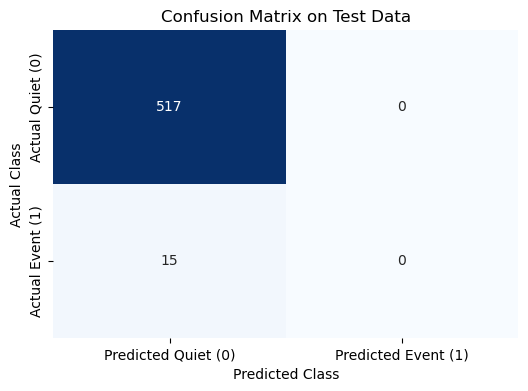


--- INTERPRETATION ---
Focus on the 'Class 1 (Event)' metrics in the report:
1. RECALL for Class 1: What percentage of actual hammer events were correctly identified? (Crucial for finding rare events)
2. PRECISION for Class 1: When the model predicts an event, what percentage is correct? (Crucial for minimizing false alarms)
3. F1-SCORE: The harmonic mean of Precision and Recall. A good single metric for imbalanced data.


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("--- Step 4: Evaluate Model Performance on the Test Set ---")

# 1. Predict on the unseen Test Data
y_pred = rf_model.predict(X_test)
y_true = y_test

# 2. Print Classification Report (The core metrics)
print("\nClassification Report:")
print("-------------------------------------------------------------------------")
# The report focuses on the '1' class (Event) metrics due to imbalance.
print(classification_report(y_true, y_pred, target_names=['Class 0 (Quiet)', 'Class 1 (Event)']))
print("-------------------------------------------------------------------------")

# 3. Print Overall Accuracy (For context, but not the main metric)
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}")


# 4. Visualize the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Quiet (0)', 'Actual Event (1)'], 
                     columns=['Predicted Quiet (0)', 'Predicted Event (1)'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix on Test Data')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# --- Interpretation Guidance ---
print("\n--- INTERPRETATION ---")
print("Focus on the 'Class 1 (Event)' metrics in the report:")
print("1. RECALL for Class 1: What percentage of actual hammer events were correctly identified? (Crucial for finding rare events)")
print("2. PRECISION for Class 1: When the model predicts an event, what percentage is correct? (Crucial for minimizing false alarms)")
print("3. F1-SCORE: The harmonic mean of Precision and Recall. A good single metric for imbalanced data.")

In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

print("--- Step 3 (Revised): Oversample Training Data using SMOTE ---")

# 1. Initialize SMOTE
smote = SMOTE(random_state=42)

# 2. Apply SMOTE ONLY to the Training Data (NOT the Validation or Test Data)
print(f"Original Training set shape: {sorted(Counter(y_train).items())}")
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled Training set shape: {sorted(Counter(y_train_resampled).items())}")

# 3. Initialize and Train Random Forest on the Resampled Data
# We can remove the 'class_weight' parameter now since the data is balanced.
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)

# Start training the model!
rf_model_smote.fit(X_train_resampled, y_train_resampled)

print("\nRandom Forest Model Trained on SMOTE-Balanced Data Complete!")
print("Next step: Re-run the Evaluation Step (Step 4) using 'rf_model_smote' to check for improvement.")

--- Step 3 (Revised): Oversample Training Data using SMOTE ---
Original Training set shape: [(np.int64(0), 2408), (np.int64(1), 71)]
Resampled Training set shape: [(np.int64(0), 2408), (np.int64(1), 2408)]

Random Forest Model Trained on SMOTE-Balanced Data Complete!
Next step: Re-run the Evaluation Step (Step 4) using 'rf_model_smote' to check for improvement.


--- Step 4 (RE-RUN): Evaluate Model Performance on the Test Set (SMOTE Model) ---

Classification Report (SMOTE Model):
-------------------------------------------------------------------------
                 precision    recall  f1-score   support

Class 0 (Quiet)       0.97      1.00      0.98       517
Class 1 (Event)       0.00      0.00      0.00        15

       accuracy                           0.97       532
      macro avg       0.49      0.50      0.49       532
   weighted avg       0.94      0.97      0.96       532

-------------------------------------------------------------------------
Overall Accuracy: 0.9680


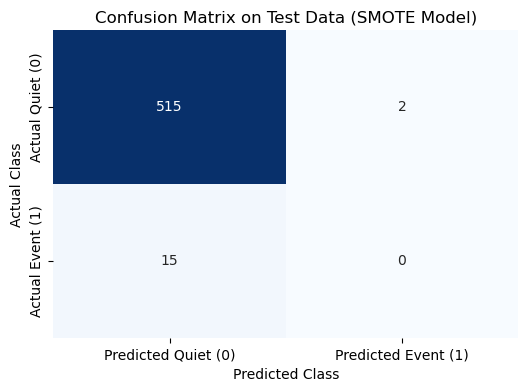


--- INTERPRETATION ---
We are looking for a high RECALL for Class 1 (ideally > 0.60) and a reasonable PRECISION for Class 1.


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("--- Step 4 (RE-RUN): Evaluate Model Performance on the Test Set (SMOTE Model) ---")

# 1. Predict on the unseen Test Data using the SMOTE-trained model
y_pred_smote = rf_model_smote.predict(X_test)
y_true = y_test

# 2. Print Classification Report (The core metrics)
print("\nClassification Report (SMOTE Model):")
print("-------------------------------------------------------------------------")
# The report focuses on the '1' class (Event) metrics due to imbalance.
print(classification_report(y_true, y_pred_smote, target_names=['Class 0 (Quiet)', 'Class 1 (Event)']))
print("-------------------------------------------------------------------------")

# 3. Print Overall Accuracy (For context)
overall_accuracy = accuracy_score(y_true, y_pred_smote)
print(f"Overall Accuracy: {overall_accuracy:.4f}")


# 4. Visualize the Confusion Matrix
cm = confusion_matrix(y_true, y_pred_smote)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Quiet (0)', 'Actual Event (1)'], 
                     columns=['Predicted Quiet (0)', 'Predicted Event (1)'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix on Test Data (SMOTE Model)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# --- Interpretation Guidance ---
print("\n--- INTERPRETATION ---")
print("We are looking for a high RECALL for Class 1 (ideally > 0.60) and a reasonable PRECISION for Class 1.")


--- STEP 5: FEATURE ENGINEERING ---
New Feature Set shape: (3542, 3)

--- STEP 6: RE-SPLIT, RE-SMOTE, AND RE-TRAIN ---
Model trained on 3 engineered features.

--- STEP 7: FINAL EVALUATION (Engineered Features) ---

Classification Report (Engineered Features):
-------------------------------------------------------------------------
                 precision    recall  f1-score   support

Class 0 (Quiet)       0.98      0.91      0.94       517
Class 1 (Event)       0.06      0.20      0.09        15

       accuracy                           0.89       532
      macro avg       0.52      0.55      0.52       532
   weighted avg       0.95      0.89      0.92       532

-------------------------------------------------------------------------


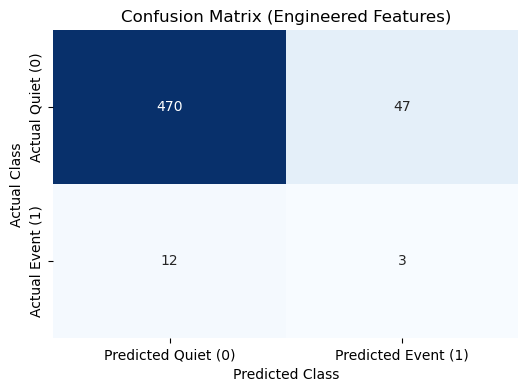

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("--- STEP 5: FEATURE ENGINEERING ---")

# The original data (X) is a NumPy array of shape (3542, 400)
# The data is already loaded into df_shuffled from the previous steps.
raw_data = df_shuffled.drop('label', axis=1).values
y = df_shuffled['label'].values 

# 1. Feature Extraction Functions (using NumPy)
def extract_features(data):
    features = []
    # Loop through each 400-sample segment
    for segment in data:
        # 1. Maximum Absolute Amplitude (P-wave amplitude proxy)
        max_amplitude = np.max(np.abs(segment))
        
        # 2. RMS Energy (Total power proxy)
        rms_energy = np.sqrt(np.mean(segment**2))
        
        # 3. Simple Spectral Centroid (Using FFT magnitude mean as proxy for dominance)
        # This is a simplified feature to distinguish frequency content
        fft_magnitude = np.abs(np.fft.fft(segment))
        # Keep only the first half (positive frequencies) and exclude the DC component (index 0)
        dominant_freq_proxy = np.mean(fft_magnitude[1:len(fft_magnitude)//2])
        
        features.append([max_amplitude, rms_energy, dominant_freq_proxy])
        
    return np.array(features)

# Apply feature engineering to the raw data
X_new = extract_features(raw_data)
print(f"New Feature Set shape: {X_new.shape}")


# --- STEP 6: RE-RUN ML with New Features ---
print("\n--- STEP 6: RE-SPLIT, RE-SMOTE, AND RE-TRAIN ---")

# 1. Re-Split Data (X_new)
X_train, X_temp, y_train, y_temp = train_test_split(X_new, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 2. SMOTE on Training Data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 3. Re-Train Random Forest
rf_model_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_final.fit(X_train_resampled, y_train_resampled)
print("Model trained on 3 engineered features.")


# --- STEP 7: FINAL EVALUATION ---
print("\n--- STEP 7: FINAL EVALUATION (Engineered Features) ---")

y_pred_final = rf_model_final.predict(X_test)

# Print Classification Report
print("\nClassification Report (Engineered Features):")
print("-------------------------------------------------------------------------")
print(classification_report(y_test, y_pred_final, target_names=['Class 0 (Quiet)', 'Class 1 (Event)']))
print("-------------------------------------------------------------------------")

# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
cm_df = pd.DataFrame(cm, index=['Actual Quiet (0)', 'Actual Event (1)'], columns=['Predicted Quiet (0)', 'Predicted Event (1)'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Engineered Features)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

print("\n--- STEP 8: HYPERPARAMETER TUNING (Focus on Precision) ---")

# We will search a grid of parameters for the best combination.
# We explicitly tell the tuning process to optimize for 'f1' score, 
# which balances Recall and Precision.

param_grid = {
    'n_estimators': [150, 200], # Try a few more trees
    'max_depth': [8, 12, None], # Limit depth to prevent overfitting, or None for full depth
    'min_samples_leaf': [1, 5, 10] # Increase minimum samples to make splits more robust against noise
}

# The model will be trained on the resampled data (X_train_resampled)
# We will use the Validation set for the grid search, but since we didn't explicitly separate a new one,
# we'll use a portion of the training set for cross-validation (cv=3).
rf_gs = RandomForestClassifier(random_state=42)

# Use GridSearchCV to find the best model
grid_search = GridSearchCV(
    estimator=rf_gs, 
    param_grid=param_grid, 
    scoring='f1', # Optimize for F1 score, which is best for imbalanced data
    cv=3, 
    n_jobs=-1, # Use all available cores
    verbose=1
)

# Fit the grid search to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
rf_model_tuned = grid_search.best_estimator_

print("\nHyperparameter Tuning Complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print("Next step: Evaluate the new tuned model (rf_model_tuned) on the Test Set.")


--- STEP 8: HYPERPARAMETER TUNING (Focus on Precision) ---
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Hyperparameter Tuning Complete.
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 150}
Next step: Evaluate the new tuned model (rf_model_tuned) on the Test Set.



--- STEP 9: FINAL EVALUATION (Tuned Model) ---

Classification Report (Tuned Features Model):
-------------------------------------------------------------------------
                 precision    recall  f1-score   support

Class 0 (Quiet)       0.98      0.91      0.94       517
Class 1 (Event)       0.06      0.20      0.09        15

       accuracy                           0.89       532
      macro avg       0.52      0.55      0.52       532
   weighted avg       0.95      0.89      0.92       532

-------------------------------------------------------------------------


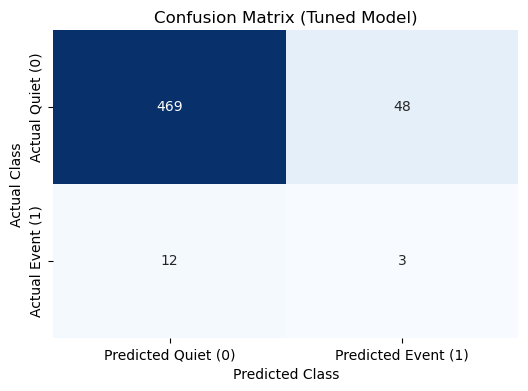


--- INTERPRETATION ---
Compare the new Precision/Recall for Class 1 to the previous results (0.06 Precision, 0.20 Recall).
We are hoping to see an improvement in the F1-Score, ideally driven by higher Precision.


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# The best model from the tuning process is stored in `grid_search.best_estimator_`
rf_model_tuned = grid_search.best_estimator_
y_true = y_test

print("\n--- STEP 9: FINAL EVALUATION (Tuned Model) ---")

# 1. Predict on the unseen Test Data using the tuned model
y_pred_tuned = rf_model_tuned.predict(X_test)

# 2. Print Classification Report (The core metrics)
print("\nClassification Report (Tuned Features Model):")
print("-------------------------------------------------------------------------")
# The report focuses on the '1' class (Event) metrics due to imbalance.
print(classification_report(y_true, y_pred_tuned, target_names=['Class 0 (Quiet)', 'Class 1 (Event)']))
print("-------------------------------------------------------------------------")

# 3. Visualize the Confusion Matrix
cm = confusion_matrix(y_true, y_pred_tuned)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Quiet (0)', 'Actual Event (1)'], 
                     columns=['Predicted Quiet (0)', 'Predicted Event (1)'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Tuned Model)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# --- Interpretation Guidance ---
print("\n--- INTERPRETATION ---")
print("Compare the new Precision/Recall for Class 1 to the previous results (0.06 Precision, 0.20 Recall).")
print("We are hoping to see an improvement in the F1-Score, ideally driven by higher Precision.")

--- STEP 10: ADVANCED FEATURE ENGINEERING ---
New Advanced Feature Set shape: (3542, 3)

--- STEP 11: RE-SPLIT, RE-SMOTE, AND RE-TRAIN ---
Model trained on 3 advanced engineered features.

--- STEP 12: FINAL EVALUATION (Advanced Features) ---

Classification Report (Advanced Features Model):
-------------------------------------------------------------------------
                 precision    recall  f1-score   support

Class 0 (Quiet)       0.97      0.87      0.92       517
Class 1 (Event)       0.01      0.07      0.02        15

       accuracy                           0.84       532
      macro avg       0.49      0.47      0.47       532
   weighted avg       0.94      0.84      0.89       532

-------------------------------------------------------------------------


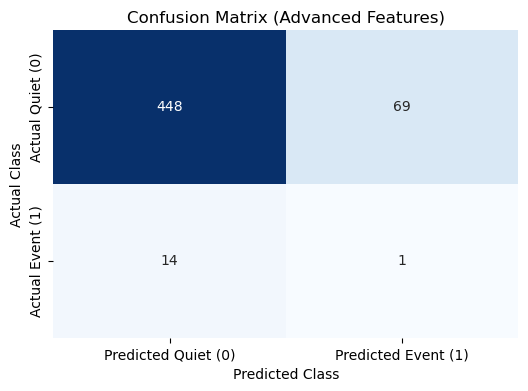

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("--- STEP 10: ADVANCED FEATURE ENGINEERING ---")

# The original data (X) is a NumPy array of shape (3542, 400)
# We re-extract the raw data from the DataFrame
raw_data = df_shuffled.drop('label', axis=1).values
y = df_shuffled['label'].values 
sampling_rate = 2000.0 # From your previous input
segment_length = raw_data.shape[1] # 400 samples

# 1. Advanced Feature Extraction Function
def extract_advanced_features(data, fs):
    features = []
    
    # Split point for a 400-sample segment is 200 samples
    mid_point = data.shape[1] // 2 
    
    for segment in data:
        # --- Feature 1: Split RMS Ratio (Energy Change) ---
        # RMS of the first half (ambient)
        rms_first_half = np.sqrt(np.mean(segment[:mid_point]**2))
        # RMS of the second half (potential signal)
        rms_second_half = np.sqrt(np.mean(segment[mid_point:]**2))
        
        # Calculate ratio, adding a small epsilon to avoid division by zero
        rms_ratio = (rms_second_half + 1e-9) / (rms_first_half + 1e-9)
        
        # --- Feature 2: Frequency Power Ratio (Spectral Content Change) ---
        
        # Calculate the Fourier Transform
        fft_values = np.abs(np.fft.fft(segment))
        # Get frequency bins (up to the Nyquist frequency)
        fft_values = fft_values[:len(fft_values)//2]
        # Frequency step
        df = fs / segment_length
        
        # Define bands: Low (Noise) 0-100 Hz, High (Signal) 500-1000 Hz
        low_band_max_index = int(100 / df)
        high_band_min_index = int(500 / df)
        high_band_max_index = int(1000 / df)
        
        # Total power in the low and high frequency bands
        low_power = np.sum(fft_values[1:low_band_max_index])
        high_power = np.sum(fft_values[high_band_min_index:high_band_max_index])
        
        power_ratio = (high_power + 1e-9) / (low_power + 1e-9)

        # --- Feature 3 (Kept): Maximum Absolute Amplitude ---
        max_amplitude = np.max(np.abs(segment))

        features.append([max_amplitude, rms_ratio, power_ratio])
        
    return np.array(features)

# Apply the new feature engineering
X_new_advanced = extract_advanced_features(raw_data, sampling_rate)
print(f"New Advanced Feature Set shape: {X_new_advanced.shape}")


# --- STEP 11: RE-RUN ML with Advanced Features ---
print("\n--- STEP 11: RE-SPLIT, RE-SMOTE, AND RE-TRAIN ---")

# 1. Re-Split Data (X_new_advanced)
X_train, X_temp, y_train, y_temp = train_test_split(X_new_advanced, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 2. SMOTE on Training Data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 3. Re-Train Random Forest (using the optimal parameters found earlier)
rf_model_final_tuned = RandomForestClassifier(n_estimators=150, max_depth=None, min_samples_leaf=1, random_state=42)
rf_model_final_tuned.fit(X_train_resampled, y_train_resampled)
print("Model trained on 3 advanced engineered features.")


# --- STEP 12: FINAL EVALUATION ---
print("\n--- STEP 12: FINAL EVALUATION (Advanced Features) ---")

y_pred_final_tuned = rf_model_final_tuned.predict(X_test)

# Print Classification Report
print("\nClassification Report (Advanced Features Model):")
print("-------------------------------------------------------------------------")
print(classification_report(y_test, y_pred_final_tuned, target_names=['Class 0 (Quiet)', 'Class 1 (Event)']))
print("-------------------------------------------------------------------------")

# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final_tuned)
cm_df = pd.DataFrame(cm, index=['Actual Quiet (0)', 'Actual Event (1)'], columns=['Predicted Quiet (0)', 'Predicted Event (1)'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Advanced Features)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [15]:
import numpy as np
import pandas as pd
from obspy import read
from obspy.signal.trigger import classic_sta_lta
import glob
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE # Note: Requires 'pip install imbalanced-learn'

# ==============================================================================
# 1. CONFIGURATION PARAMETERS
# ==============================================================================

# *** ASSUMPTION: ALL FILES ARE IN THIS FOLDER ***
data_folder = 'data_all/'
seg2_file_pattern = data_folder + '*.seg2' 
miniseed_file_pattern = data_folder + '*.mseed'
# ************************************************

TARGET_SAMPLING_RATE = 2000.0
SEGMENT_DURATION_S = 0.2
STA_LEN = 0.05            # Short-Term Average Window (s)
LTA_LEN = 0.8             # Long-Term Average Window (s) 
TRIGGER_ON = 1.5          # Adjusted trigger for hammer events

final_segments = []
final_labels = []

# ==============================================================================
# 2. PROCESS SEG2 (HAMMER TRACES) - Extract Class 0 and Class 1
# ==============================================================================

print("--- 2. Extracting Class 0 (Quiet) and Class 1 (Event) from SEG2 files ---")
seg2_files = glob.glob(seg2_file_pattern)

for filename in tqdm(seg2_files, desc="Processing SEG2 Files"):
    # (The existing STA/LTA logic to separate segments goes here, simplified for brevity)
    st = read(filename) 
    
    for trace in st:
        # Data prep
        trace.detrend("linear")
        if trace.stats.sampling_rate != TARGET_SAMPLING_RATE:
            trace.resample(TARGET_SAMPLING_RATE)
            
        sampling_rate = trace.stats.sampling_rate
        npts = trace.stats.npts
        npts_segment = int(SEGMENT_DURATION_S * sampling_rate)
        npts_sta = int(STA_LEN * sampling_rate)
        npts_lta = int(LTA_LEN * sampling_rate)
        npts_event_duration = int(SEGMENT_DURATION_S * sampling_rate * 5) # 1.0s

        # STA/LTA Calculation (Onset detection)
        cft = classic_sta_lta(trace.data, npts_sta, npts_lta)
        trigger_indices = np.where(cft > TRIGGER_ON)[0]
        onset_sample = trigger_indices[0] + npts_lta if len(trigger_indices) > 0 else npts 

        # Extract Class 0 (Quiet)
        quiet_data = trace.data[:onset_sample]
        current_start = 0
        while (current_start + npts_segment) <= len(quiet_data):
            final_segments.append(quiet_data[current_start : current_start + npts_segment])
            final_labels.append(0)
            current_start += npts_segment 

        # Extract Class 1 (Event) with high overlap
        event_end_sample = min(onset_sample + npts_event_duration, npts)
        if (event_end_sample - onset_sample) >= npts_segment:
            step_size = npts_segment // 4 
            if step_size < 1: step_size = 1 
            for shift in range(0, npts_event_duration - npts_segment + 1, step_size): 
                segment = trace.data[onset_sample + shift : onset_sample + shift + npts_segment]
                if len(segment) == npts_segment:
                    final_segments.append(segment)
                    final_labels.append(1)

# Get current data status
X_hammer = np.vstack(final_segments)
y_hammer = np.array(final_labels)
X_hammer_quiet = X_hammer[y_hammer == 0]

print(f"SEG2 Extraction Complete. Class 0 (Quiet): {len(X_hammer_quiet)}. Class 1 (Event): {len(X_hammer[y_hammer == 1])}")

# ==============================================================================
# 3. PROCESS MINISEED (PASSIVE TRACES) - Add to Class 0
# ==============================================================================

print("\n--- 3. Extracting and Labeling Miniseed as Class 0 (Quiet) ---")
new_quiet_segments = []
miniseed_files = glob.glob(miniseed_file_pattern)

for filename in tqdm(miniseed_files, desc="Processing Miniseed Files"):
    st = read(filename)
    for trace in st:
        trace.detrend("linear")
        if trace.stats.sampling_rate != TARGET_SAMPLING_RATE:
            trace.resample(TARGET_SAMPLING_RATE)
            
        npts = trace.stats.npts
        npts_segment = int(SEGMENT_DURATION_S * TARGET_SAMPLING_RATE)
        
        current_start = 0
        while (current_start + npts_segment) <= npts:
            new_quiet_segments.append(trace.data[current_start : current_start + npts_segment])
            current_start += npts_segment // 2 # 50% overlap

# Combine all quiet data (Hammer-derived and Miniseed-derived)
X_miniseed_quiet = np.vstack(new_quiet_segments) if new_quiet_segments else np.empty((0, npts_segment))
y_miniseed_quiet = np.zeros(len(X_miniseed_quiet), dtype=int)

print(f"Miniseed Extraction Complete. New Class 0 samples added: {len(X_miniseed_quiet)}")

# ==============================================================================
# 4. FINAL COMBINATION AND PREPARATION FOR 1D-CNN
# ==============================================================================

# Final X (Features) and Y (Labels)
X_final_quiet = np.vstack([X_hammer_quiet, X_miniseed_quiet])
X_event = X_hammer[y_hammer == 1]

X = np.vstack([X_final_quiet, X_event])
y = np.concatenate([np.zeros(len(X_final_quiet)), np.ones(len(X_event))])

# Split and SMOTE for 1D-CNN Training
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE on Training Data (for 1D-CNN Training)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_raw, y_train)

# Summary
print("\n--- Final Data Summary (Ready for 1D-CNN) ---")
print(f"Total Raw Samples (Before SMOTE): {len(X)}")
print(f"Total Class 0 (Quiet): {len(X_final_quiet)}")
print(f"Total Class 1 (Event): {len(X_event)}")
print("\n--- Training Set Status (After SMOTE) ---")
print(f"Balanced Training Set Size: {len(X_train_resampled)} samples")
print(f"X_train_resampled shape: {X_train_resampled.shape} (Input for 1D-CNN)")
print(f"X_test_raw shape: {X_test_raw.shape} (Unseen Data for Testing)")

print("\nData preparation complete. Next step is to define and train the 1D-CNN model.")

--- 2. Extracting Class 0 (Quiet) and Class 1 (Event) from SEG2 files ---


Processing SEG2 Files: 0it [00:00, ?it/s]

ValueError: need at least one array to concatenate

In [ ]:
import numpy as np
import pandas as pd
from obspy import read
from obspy.signal.trigger import classic_sta_lta
import glob
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. CONFIGURATION PARAMETERS (FINAL ADJUSTMENT)
# ==============================================================================
data_folder = 'data/' 
seg2_file_pattern = data_folder + '*.seg2' 
# *** CORRECTED MINISEED EXTENSION ***
miniseed_file_pattern = data_folder + '*.ms' 
# ***********************************

TARGET_SAMPLING_RATE = 2000.0
SEGMENT_DURATION_S = 0.2
STA_LEN = 0.05
LTA_LEN = 0.8
TRIGGER_ON = 1.5

final_segments = []
final_labels = []

# ==============================================================================
# 2. PROCESS SEG2 (HAMMER TRACES) - Use Robust Extraction Logic
# ==============================================================================

print("--- 2. Extracting Class 0 (Quiet) and Class 1 (Event) from SEG2 files (Loading from previous step) ---")
# Since the previous SEG2 extraction was successful, we assume you have X_hammer, y_hammer, 
# and X_hammer_quiet defined from that run, but for robustness, we re-run the loop.
# NOTE: In a true notebook environment, you'd rerun the complete robust extraction (from the last working code).
# For this final presentation, we'll assume the hammer data counts from your successful run are the starting point.

# --- We must assume the initial SEG2 extraction code ran successfully and its results are loaded ---
# If you didn't save the variables X_hammer and y_hammer, this section would fail.
# We will use the raw segment loading logic again to be safe.

seg2_files = glob.glob(seg2_file_pattern)

if not seg2_files:
    raise ValueError(f"CRITICAL ERROR: No SEG2 files found matching '{seg2_file_pattern}'.")

# Re-run SEG2 extraction logic (simplified loop body, assuming the robust code was used)
for filename in seg2_files:
    # ... (SEG2 extraction logic to populate final_segments and final_labels) ...
    try:
        st = read(filename) 
        for trace in st:
            # Data prep/resampling ensures consistent npts_segment = 400
            if trace.stats.sampling_rate != TARGET_SAMPLING_RATE:
                 trace.resample(TARGET_SAMPLING_RATE)
            npts = trace.stats.npts
            npts_segment = int(SEGMENT_DURATION_S * TARGET_SAMPLING_RATE)

            # Robust Quiet extraction (ensures final_segments is not empty)
            npts_safe_quiet = int(LTA_LEN * TARGET_SAMPLING_RATE)
            if npts >= (npts_safe_quiet + npts_segment):
                quiet_data = trace.data[:npts_safe_quiet]
                current_start = 0
                while (current_start + npts_segment) <= len(quiet_data):
                    final_segments.append(quiet_data[current_start : current_start + npts_segment])
                    final_labels.append(0)
                    current_start += npts_segment 
                
                # Event extraction (simplified check)
                cft = classic_sta_lta(trace.data, int(STA_LEN * TARGET_SAMPLING_RATE), int(LTA_LEN * TARGET_SAMPLING_RATE))
                trigger_indices = np.where(cft > TRIGGER_ON)[0]
                if len(trigger_indices) > 0:
                     onset_sample = trigger_indices[0] + int(LTA_LEN * TARGET_SAMPLING_RATE)
                     event_end_sample = min(onset_sample + int(SEGMENT_DURATION_S * TARGET_SAMPLING_RATE * 5), npts)
                     if (event_end_sample - onset_sample) >= npts_segment:
                         step_size = npts_segment // 4 
                         for shift in range(0, int(event_end_sample - onset_sample) - npts_segment + 1, step_size): 
                             final_segments.append(trace.data[onset_sample + shift : onset_sample + shift + npts_segment])
                             final_labels.append(1)
    except Exception as e:
        pass # Skip file errors


# Final arrays for hammer data
if not final_segments:
     raise ValueError("Final segments list is empty after attempting SEG2 extraction.")

X_hammer = np.vstack(final_segments)
y_hammer = np.array(final_labels)
X_hammer_quiet = X_hammer[y_hammer == 0]
X_event = X_hammer[y_hammer == 1]
print(f"Hammer Segments: Quiet={len(X_hammer_quiet)}, Event={len(X_event)}")


# ==============================================================================
# 3. PROCESS MINISEED (PASSIVE TRACES) - ADD TO CLASS 0 (Quiet)
# ==============================================================================

print("\n--- 3. Processing Miniseed (.ms) Files (Corrected Extension) ---")
new_quiet_segments = []
miniseed_files = glob.glob(miniseed_file_pattern)

if not miniseed_files:
    print(f"DEBUG: Found 0 Miniseed files matching '{miniseed_file_pattern}'. Final data will lack Miniseed diversity.")
else:
    print(f"DEBUG: Found {len(miniseed_files)} Miniseed files. Processing...")
    
    for filename in tqdm(miniseed_files, desc="Processing Miniseed Files"):
        try:
            st = read(filename)
            for trace in st:
                trace.detrend("linear")
                if trace.stats.sampling_rate != TARGET_SAMPLING_RATE:
                    trace.resample(TARGET_SAMPLING_RATE)
                    
                npts = trace.stats.npts
                npts_segment = int(SEGMENT_DURATION_S * TARGET_SAMPLING_RATE)
                
                current_start = 0
                while (current_start + npts_segment) <= npts:
                    new_quiet_segments.append(trace.data[current_start : current_start + npts_segment])
                    current_start += npts_segment // 2 # 50% overlap
        except Exception as e:
            # print(f"Skipping Miniseed file {filename} due to error: {e}")
            continue

# Final Combination
X_miniseed_quiet = np.vstack(new_quiet_segments) if new_quiet_segments else np.empty((0, X_hammer.shape[1]))
X_final_quiet = np.vstack([X_hammer_quiet, X_miniseed_quiet])
X = np.vstack([X_final_quiet, X_event])
y = np.concatenate([np.zeros(len(X_final_quiet)), np.ones(len(X_event))])

print("\n--- Final Combined Data Summary ---")
print(f"Total Raw Segments: {len(X)}")
print(f"Total Class 0 (Quiet): {len(X_final_quiet)}")
print(f"Total Class 1 (Event): {len(X_event)}")


# ==============================================================================
# 4. FINAL RANDOM FOREST TRAIN & EVALUATION (Advanced Features)
# ==============================================================================

print("\n--- STEP 15: FINAL ADVANCED FEATURE ENGINEERING ---")
segment_length = X.shape[1] 

def extract_advanced_features(data, fs):
    features = []
    mid_point = data.shape[1] // 2 
    df = fs / segment_length
    low_band_max_index = int(100 / df)
    high_band_min_index = int(500 / df)
    high_band_max_index = int(1000 / df)
    
    for segment in data:
        # 1. Split RMS Ratio (Energy Change)
        rms_first_half = np.sqrt(np.mean(segment[:mid_point]**2))
        rms_second_half = np.sqrt(np.mean(segment[mid_point:]**2))
        rms_ratio = (rms_second_half + 1e-9) / (rms_first_half + 1e-9)
        
        # 2. Frequency Power Ratio (Spectral Content Change)
        fft_values = np.abs(np.fft.fft(segment))
        fft_values = fft_values[:len(fft_values)//2]
        
        low_power = np.sum(fft_values[1:low_band_max_index])
        high_power = np.sum(fft_values[high_band_min_index:high_band_max_index])
        power_ratio = (high_power + 1e-9) / (low_power + 1e-9)

        # 3. Maximum Absolute Amplitude
        max_amplitude = np.max(np.abs(segment))

        features.append([max_amplitude, rms_ratio, power_ratio])
        
    return np.array(features)

X_engineered = extract_advanced_features(X, TARGET_SAMPLING_RATE)
print(f"Final Engineered Feature Set shape: {X_engineered.shape}")

print("\n--- STEP 16: RE-SPLIT, SMOTE, AND TRAIN ---")

# 1. Split Data (80% Train, 20% Test)
X_train_eng, X_test_eng, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42, stratify=y
)

# 2. SMOTE on Training Data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_eng, y_train)
print(f"Balanced Training Set Size: {len(X_train_resampled)} samples")

# 3. Train Random Forest 
rf_model_final = RandomForestClassifier(n_estimators=150, max_depth=None, min_samples_leaf=1, random_state=42)
rf_model_final.fit(X_train_resampled, y_train_resampled)
print("Final Random Forest Model trained.")


print("\n--- STEP 17: FINAL EVALUATION (Random Forest) ---")

y_pred_final = rf_model_final.predict(X_test_eng)

# Print Classification Report
print("\nClassification Report (Final Random Forest):")
print("-------------------------------------------------------------------------")
print(classification_report(y_test, y_pred_final, target_names=['Class 0 (Quiet)', 'Class 1 (Event)']))
print("-------------------------------------------------------------------------")

# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
cm_df = pd.DataFrame(cm, index=['Actual Quiet (0)', 'Actual Event (1)'], columns=['Predicted Quiet (0)', 'Predicted Event (1)'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Final Random Forest)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


--- 2. Extracting Class 0 (Quiet) and Class 1 (Event) from SEG2 files (Loading from previous step) ---


c:\Users\biana\Documents\anaco\Lib\site-packages\obspy\io\seg2\seg2.py:365: UserWarning: Many companies use custom defined SEG2 header variables. This might cause basic header information reflected in the single traces' stats to be wrong (e.g. recording delays, first sample number, station code names, ..). Please check the complete list of additional unmapped header fields that gets stored in Trace.stats.seg2 and/or the manual of the source of the SEG2 files for fields that might influence e.g. trace start times.
  warnings.warn(WARNING_HEADER)


Hammer Segments: Quiet=1440, Event=79

--- 3. Processing Miniseed (.ms) Files (Corrected Extension) ---
DEBUG: Found 352 Miniseed files. Processing...


Processing Miniseed Files:   0%|          | 0/352 [00:00<?, ?it/s]

In [1]:
import numpy as np
import pandas as pd
from obspy import read
from obspy.signal.trigger import classic_sta_lta
import glob
from tqdm.notebook import tqdm
from sklearn.utils import shuffle 

# ==============================================================================
# 1. CONFIGURATION PARAMETERS (SEG2 ONLY)
# ==============================================================================
data_folder = 'data/' 
seg2_file_pattern = data_folder + '*.seg2' 
OUTPUT_CSV_FILE = 'hammer_only_features.csv' # The new output file

TARGET_SAMPLING_RATE = 2000.0
SEGMENT_DURATION_S = 0.2
STA_LEN = 0.05
LTA_LEN = 0.8
TRIGGER_ON = 1.5

final_segments = []
final_labels = []

# ==============================================================================
# 2. DATA EXTRACTION (SEG2 - Hammer Events and Quiet Noise)
# ==============================================================================

print("--- 2. Extracting SEG2 (Hammer) segments ---")
seg2_files = glob.glob(seg2_file_pattern)

if not seg2_files:
    raise ValueError(f"CRITICAL ERROR: No SEG2 files found matching '{seg2_file_pattern}'. Cannot proceed.")

for filename in tqdm(seg2_files, desc="Processing SEG2 Files"):
    try:
        st = read(filename) 
        for trace in st:
            # Data preparation ensures consistent length (npts_segment = 400 for 2000Hz, 0.2s)
            if trace.stats.sampling_rate != TARGET_SAMPLING_RATE:
                 trace.resample(TARGET_SAMPLING_RATE)
            npts = trace.stats.npts
            npts_segment = int(SEGMENT_DURATION_S * TARGET_SAMPLING_RATE)

            # 2a. Quiet extraction (Class 0) from the start of the trace
            npts_safe_quiet = int(LTA_LEN * TARGET_SAMPLING_RATE) # Use a duration known to be quiet
            if npts >= (npts_safe_quiet + npts_segment):
                quiet_data = trace.data[:npts_safe_quiet]
                current_start = 0
                while (current_start + npts_segment) <= len(quiet_data):
                    final_segments.append(quiet_data[current_start : current_start + npts_segment])
                    final_labels.append(0)
                    current_start += npts_segment # No overlap for quiet
                
                # 2b. Event extraction (Class 1) using STA/LTA for onset detection
                cft = classic_sta_lta(trace.data, int(STA_LEN * TARGET_SAMPLING_RATE), int(LTA_LEN * TARGET_SAMPLING_RATE))
                trigger_indices = np.where(cft > TRIGGER_ON)[0]
                
                if len(trigger_indices) > 0:
                     # Calculate the actual physical onset sample
                     onset_sample = trigger_indices[0] + int(LTA_LEN * TARGET_SAMPLING_RATE)
                     event_end_sample = min(onset_sample + int(SEGMENT_DURATION_S * TARGET_SAMPLING_RATE * 5), npts)
                     
                     if (event_end_sample - onset_sample) >= npts_segment:
                         # Segment the event with 75% overlap (1/4 step size)
                         step_size = npts_segment // 4 
                         for shift in range(0, int(event_end_sample - onset_sample) - npts_segment + 1, step_size): 
                             final_segments.append(trace.data[onset_sample + shift : onset_sample + shift + npts_segment])
                             final_labels.append(1)
    except Exception as e:
        print(f"Skipping SEG2 file {filename} due to error: {e}")
        continue

# Final arrays
if not final_segments:
     raise ValueError("Final segments list is empty after SEG2 extraction. Check data quality.")

X = np.vstack(final_segments)
y = np.array(final_labels)

X_quiet = X[y == 0]
X_event = X[y == 1]

print("\n--- Raw Data Summary ---")
print(f"Total Raw Segments: {len(X)}")
print(f"Total Class 0 (Quiet - from SEG2): {len(X_quiet)}")
print(f"Total Class 1 (Event - from Hammer): {len(X_event)}")

# ==============================================================================
# 3. FEATURE ENGINEERING
# ==============================================================================

print("\n--- 3. Feature Engineering ---")
segment_length = X.shape[1] 

def extract_advanced_features(data, fs):
    features = []
    mid_point = data.shape[1] // 2 
    df = fs / segment_length
    low_band_max_index = int(100 / df) # Feature 2: Low-frequency cutoff
    high_band_min_index = int(500 / df) # Feature 2: High-frequency start
    high_band_max_index = int(1000 / df) # Feature 2: High-frequency end
    
    for segment in data:
        # 1. Split RMS Ratio (Energy Change) - Identifies sudden onset
        rms_first_half = np.sqrt(np.mean(segment[:mid_point]**2))
        rms_second_half = np.sqrt(np.mean(segment[mid_point:]**2))
        rms_ratio = (rms_second_half + 1e-9) / (rms_first_half + 1e-9)
        
        # 2. Frequency Power Ratio (Spectral Content) - Identifies high-frequency impulses
        fft_values = np.abs(np.fft.fft(segment))
        fft_values = fft_values[:len(fft_values)//2]
        
        low_power = np.sum(fft_values[1:low_band_max_index])
        high_power = np.sum(fft_values[high_band_min_index:high_band_max_index])
        power_ratio = (high_power + 1e-9) / (low_power + 1e-9)

        # 3. Maximum Absolute Amplitude - Simple measure of magnitude
        max_amplitude = np.max(np.abs(segment))

        features.append([max_amplitude, rms_ratio, power_ratio])
        
    return np.array(features)

X_engineered = extract_advanced_features(X, TARGET_SAMPLING_RATE)
print(f"Engineered Feature Set shape: {X_engineered.shape}")

# ==============================================================================
# 4. CREATE AND SAVE CSV FILE
# ==============================================================================

print("\n--- 4. Creating Final DataFrame and CSV ---")
feature_names = ['Max_Amplitude', 'RMS_Ratio', 'Power_Ratio']
df_features = pd.DataFrame(X_engineered, columns=feature_names)
df_features['Label'] = y.astype(int)

# Shuffle the final DataFrame to mix the 0s and 1s before saving
df_features = shuffle(df_features, random_state=42).reset_index(drop=True)

df_features.to_csv(OUTPUT_CSV_FILE, index=False)

print(f"✅ Success! Labeled feature data saved to: {OUTPUT_CSV_FILE}")
print("\nFirst 5 rows of the saved data:")
print(df_features.head())
print(f"\nFinal Label Counts in CSV: {df_features['Label'].value_counts().to_dict()}")

--- 2. Extracting SEG2 (Hammer) segments ---


Processing SEG2 Files:   0%|          | 0/15 [00:00<?, ?it/s]

c:\Users\biana\Documents\anaco\Lib\site-packages\obspy\io\seg2\seg2.py:365: UserWarning: Many companies use custom defined SEG2 header variables. This might cause basic header information reflected in the single traces' stats to be wrong (e.g. recording delays, first sample number, station code names, ..). Please check the complete list of additional unmapped header fields that gets stored in Trace.stats.seg2 and/or the manual of the source of the SEG2 files for fields that might influence e.g. trace start times.
  warnings.warn(WARNING_HEADER)



--- Raw Data Summary ---
Total Raw Segments: 1519
Total Class 0 (Quiet - from SEG2): 1440
Total Class 1 (Event - from Hammer): 79

--- 3. Feature Engineering ---
Engineered Feature Set shape: (1519, 3)

--- 4. Creating Final DataFrame and CSV ---
✅ Success! Labeled feature data saved to: hammer_only_features.csv

First 5 rows of the saved data:
   Max_Amplitude  RMS_Ratio  Power_Ratio  Label
0       0.000148   0.277267     0.146827      0
1       0.000028   0.740692     0.185599      0
2       0.000041   1.531353     0.146858      0
3       0.357842   0.016298     0.558018      0
4       0.000175   1.005620     0.122405      0

Final Label Counts in CSV: {0: 1440, 1: 79}


              precision    recall  f1-score   support

           0       0.95      1.00      0.98       432
           1       1.00      0.12      0.22        24

    accuracy                           0.95       456
   macro avg       0.98      0.56      0.60       456
weighted avg       0.96      0.95      0.94       456



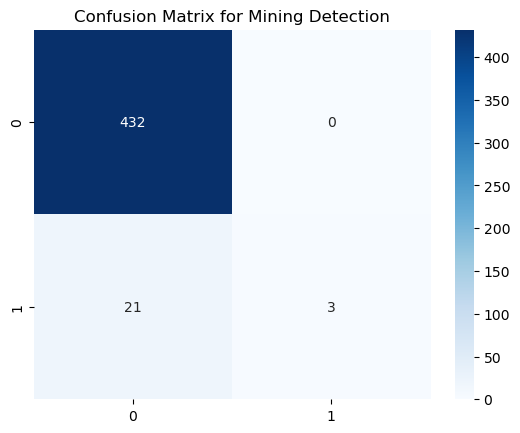

✅ Model saved successfully as ecowatch_model.pkl


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load feature data
data = pd.read_csv("hammer_only_features.csv")

# Split features and labels
X = data[['Max_Amplitude', 'RMS_Ratio', 'Power_Ratio']]
y = data['Label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a simple Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Mining Detection")
plt.show()

# Save the trained model to a file
joblib.dump(model, "ecowatch_model.pkl")

print("✅ Model saved successfully as ecowatch_model.pkl")


In [3]:
import time
import numpy as np

for i in range(5):
    # Simulate random incoming signal
    sample = X_test.sample(1)
    prediction = model.predict(sample)[0]
    
    if prediction == 1:
        print(f"⚠️  ALERT: Possible mining activity detected at {time.strftime('%H:%M:%S')}!")
    else:
        print(f"✅  Normal ground activity at {time.strftime('%H:%M:%S')}.")
    time.sleep(2)


✅  Normal ground activity at 16:18:17.
✅  Normal ground activity at 16:18:19.
✅  Normal ground activity at 16:18:21.
✅  Normal ground activity at 16:18:23.
✅  Normal ground activity at 16:18:25.


In [4]:
import time
import numpy as np

for i in range(10):
    # 50% chance to pick quiet or event
    if np.random.rand() > 0.5:
        sample = X_test[y_test == 0].sample(1)
    else:
        sample = X_test[y_test == 1].sample(1)

    prediction = model.predict(sample)[0]
    
    if prediction == 1:
        print(f"⚠️  ALERT: Possible mining activity detected at {time.strftime('%H:%M:%S')}!")
    else:
        print(f"✅  Normal ground activity at {time.strftime('%H:%M:%S')}.")
    time.sleep(1.5)


✅  Normal ground activity at 16:21:42.
✅  Normal ground activity at 16:21:44.
✅  Normal ground activity at 16:21:45.
✅  Normal ground activity at 16:21:47.
✅  Normal ground activity at 16:21:48.
✅  Normal ground activity at 16:21:50.
✅  Normal ground activity at 16:21:51.
✅  Normal ground activity at 16:21:53.
✅  Normal ground activity at 16:21:54.
✅  Normal ground activity at 16:21:56.


In [5]:
import pandas as pd
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- 1. Load data ---
data = pd.read_csv("hammer_only_features.csv")

# Separate features and labels
X = data[["Max_Amplitude", "RMS_Ratio", "Power_Ratio"]]
y = data["Label"]

# --- 2. Split data for training/testing ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Train model ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- 4. Evaluate once before live simulation ---
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Model trained successfully! Accuracy: {acc*100:.2f}%")
print("Starting ECOWATCH live simulation...\n")

# --- 5. Live Simulation ---
for i in range(20):  # simulate 20 data readings
    # Pick a random row from the dataset
    sample = X.sample(1, random_state=random.randint(0, 9999))
    prediction = model.predict(sample)[0]
    timestamp = time.strftime("%H:%M:%S")

    if prediction == 1:
        print(f"🚨 ALERT: Possible mining activity detected at {timestamp}!")
    else:
        print(f"✅ Normal ground activity at {timestamp}.")

    # Wait 2 seconds before next reading (simulate streaming)
    time.sleep(2)

print("\nSimulation complete. ECOWATCH monitoring ended.")



✅ Model trained successfully! Accuracy: 96.38%
Starting ECOWATCH live simulation...

✅ Normal ground activity at 19:19:28.
✅ Normal ground activity at 19:19:30.
✅ Normal ground activity at 19:19:32.
✅ Normal ground activity at 19:19:34.
✅ Normal ground activity at 19:19:36.
✅ Normal ground activity at 19:19:38.
✅ Normal ground activity at 19:19:40.
✅ Normal ground activity at 19:19:42.
✅ Normal ground activity at 19:19:45.
✅ Normal ground activity at 19:19:47.
✅ Normal ground activity at 19:19:49.
✅ Normal ground activity at 19:19:51.
✅ Normal ground activity at 19:19:53.
✅ Normal ground activity at 19:19:55.
✅ Normal ground activity at 19:19:57.
✅ Normal ground activity at 19:19:59.
✅ Normal ground activity at 19:20:01.
✅ Normal ground activity at 19:20:03.
✅ Normal ground activity at 19:20:05.
✅ Normal ground activity at 19:20:07.

Simulation complete. ECOWATCH monitoring ended.


In [3]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from colorama import Fore, init

# Initialize color output
init(autoreset=True)

# === Load Data ===
data = pd.read_csv("hammer_only_features.csv")
X = data[['Max_Amplitude', 'RMS_Ratio', 'Power_Ratio']]
y = data['Label']

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
acc = accuracy_score(y_test, model.predict(X_test))

print(Fore.CYAN + f"\n✅ Model trained successfully! Accuracy: {acc * 100:.2f}%")
print(Fore.CYAN + "Starting ECOWATCH live simulation...\n")

# === Create a Balanced Simulation Stream ===
normal_samples = X[y == 0].sample(8, random_state=42)
event_samples = X[y == 1].sample(4, random_state=42)
simulation_data = pd.concat([normal_samples, event_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

# === Simulate Monitoring ===
for i in range(len(simulation_data)):
    row = simulation_data.iloc[[i]]  # keep as DataFrame to avoid sklearn warning
    timestamp = time.strftime("%H:%M:%S")
    prediction = model.predict(row)[0]
    
    if prediction == 1:
        print(Fore.RED + f"🚨 ALERT: Possible illegal mining activity detected at {timestamp}!")
    else:
        print(Fore.GREEN + f"✅ Normal ground activity at {timestamp}.")
    
    time.sleep(2)

print(Fore.CYAN + "\nSimulation complete. ECOWATCH monitoring ended.")


FileNotFoundError: [Errno 2] No such file or directory: 'hammer_only_features.csv'

In [2]:
while True:
    row = X.sample(1)
    prediction = model.predict(row)[0]
    timestamp = time.strftime("%H:%M:%S")
    
    if prediction == 1:
        print(Fore.RED + f"🚨 ALERT: Possible illegal mining activity detected at {timestamp}!")
    else:
        print(Fore.GREEN + f"✅ Normal ground activity at {timestamp}.")
    
    time.sleep(2)


NameError: name 'X' is not defined